In [65]:
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.datasets import fetch_openml
from sklearn.metrics import mean_squared_error

from IPython.display import Image

In [66]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
mpl.rcParams.update({"axes.grid": True})

In [67]:
df = fetch_openml(data_id=534, as_frame=True).frame

In [87]:
df = df.query("WAGE > 1 and WAGE < 30")  # snip 2 outliers

In [69]:
df.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


In [70]:
target_feature = "WAGE"
numeric_features = df.columns[df.dtypes != "category"].to_list()
numeric_features.remove(target_feature)
one_hot_features = df.columns[df.dtypes == "category"].to_list()
display([numeric_features, one_hot_features])

[['EDUCATION', 'EXPERIENCE', 'AGE'],
 ['SOUTH', 'SEX', 'UNION', 'RACE', 'OCCUPATION', 'SECTOR', 'MARR']]

In [71]:
numeric_features_prefix = ["numeric_" + name for name in numeric_features]
one_hot_features_prefix = ["category_" + name for name in one_hot_features]
df = df.rename(columns=dict(zip(one_hot_features, one_hot_features_prefix))).rename(
    columns=dict(zip(numeric_features, numeric_features_prefix))
)

numeric_features = numeric_features_prefix
one_hot_features = one_hot_features_prefix

In [72]:
X = df.drop(columns=target_feature)
y = df[target_feature]

In [73]:
ohe_pipe = Pipeline(
    [
        (
            "ohe",
            make_column_transformer(
                (
                    OneHotEncoder(drop="if_binary"),
                    one_hot_features,
                ),
            ),
        ),
    ]
).fit(X, y)

display(ohe_pipe)

Pipeline(steps=[('ohe',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['category_SOUTH',
                                                   'category_SEX',
                                                   'category_UNION',
                                                   'category_RACE',
                                                   'category_OCCUPATION',
                                                   'category_SECTOR',
                                                   'category_MARR'])]))])

In [74]:
# pd.DataFrame(ohe_pipe.transform(X), columns=ohe_pipe.get_feature_names_out())

In [75]:
poly_pipe = Pipeline(
    [
        (
            "prescale",
            make_column_transformer(
                (
                    StandardScaler(),
                    numeric_features,
                ),
            ),
        ),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("postscale", StandardScaler()),
    ]
).fit(X, y)

display(poly_pipe)

Pipeline(steps=[('prescale',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['numeric_EDUCATION',
                                                   'numeric_EXPERIENCE',
                                                   'numeric_AGE'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('postscale', StandardScaler())])

In [76]:
# pd.DataFrame(
#     poly_pipe.transform(X), columns=poly_pipe.get_feature_names_out()
# )

In [77]:
feature_pipe = FeatureUnion(
    [
        ("poly", poly_pipe),
        ("ohe", ohe_pipe),
    ]
).fit(X, y)

display(feature_pipe)

FeatureUnion(transformer_list=[('poly',
                                Pipeline(steps=[('prescale',
                                                 ColumnTransformer(transformers=[('standardscaler',
                                                                                  StandardScaler(),
                                                                                  ['numeric_EDUCATION',
                                                                                   'numeric_EXPERIENCE',
                                                                                   'numeric_AGE'])])),
                                                ('poly',
                                                 PolynomialFeatures(include_bias=False)),
                                                ('postscale',
                                                 StandardScaler())])),
                               ('ohe',
                                Pipeline(steps=[('ohe',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary'),
                                                                                  ['category_SOUTH',
                                                                                   'category_SEX',
                                                                                   'category_UNION',
                                                                                   'category_RACE',
                                                                                   'category_OCCUPATION',
                                                                                   'category_SECTOR',
                                                                                   'category_MARR'])]))]))])

In [78]:
# pd.DataFrame(
#     feature_pipe.transform(X), columns=feature_pipe.get_feature_names_out()
# )

In [79]:
processing_pipe = Pipeline(
    [
        ("features", feature_pipe),
        ("regression", Ridge(fit_intercept=True)),
    ]
).fit(X, y)

display(processing_pipe)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('poly',
                                                 Pipeline(steps=[('prescale',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['numeric_EDUCATION',
                                                                                                    'numeric_EXPERIENCE',
                                                                                                    'numeric_AGE'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(include_bias=False)),
                                                                 ('postscale',
                                                                  StandardScaler())])),
                                                ('ohe',
                                                 Pipeline(steps=[('ohe',
                                                                  ColumnTransformer(transformers=[('onehotencoder',
                                                                                                   OneHotEncoder(drop='if_binary'),
                                                                                                   ['category_SOUTH',
                                                                                                    'category_SEX',
                                                                                                    'category_UNION',
                                                                                                    'category_RACE',
                                                                                                    'category_OCCUPATION',
                                                                                                    'category_SECTOR',
                                                                                                    'category_MARR'])]))]))])),
                ('regression', Ridge())])

In [80]:
regression_pipe = Pipeline(
    [
        (
            "ttr",
            TransformedTargetRegressor(
                regressor=processing_pipe, func=np.log, inverse_func=np.exp
            ),
        )
    ]
).fit(X, y)

regression_pipe

Pipeline(steps=[('ttr',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Pipeline(steps=[('features',
                                                                       FeatureUnion(transformer_list=[('poly',
                                                                                                       Pipeline(steps=[('prescale',
                                                                                                                        ColumnTransformer(transformers=[('standardscaler',
                                                                                                                                                         StandardScaler(),
                                                                                                                                                         ['numeric_EDUCATION',
                                                                                                                                                          'numeric_EXPERIENCE',
                                                                                                                                                          'numeric_AGE'])])),
                                                                                                                       ('poly',
                                                                                                                        PolynomialFeatures(include_bias=False)),
                                                                                                                       ('postscale',
                                                                                                                        StandardScaler())])),
                                                                                                      ('ohe',
                                                                                                       Pipeline(steps=[('ohe',
                                                                                                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                                                                                                         OneHotEncoder(drop='if_binary'),
                                                                                                                                                         ['category_SOUTH',
                                                                                                                                                          'category_SEX',
                                                                                                                                                          'category_UNION',
                                                                                                                                                          'category_RACE',
                                                                                                                                                          'category_OCCUPATION',
                                                                                                                                                          'category_SECTOR',
                                                                                                                                                          'category_MARR'])]))]))])),
                                                                      ('regression',
                                                                       Ridge())])))])

In [86]:
y_pred = regression_pipe.predict(X)
mse_basic = mean_squared_error(y, y_pred)  # was - 18.416299035907095
mse_basic

15.48489183890149

In [89]:
(train_inds, dev_inds) = train_test_split(
    range(len(df)), random_state=42, train_size=0.75
)

In [90]:
alpha_list = 10 ** np.linspace(-5, 5, 51)
degree_list = range(1, 4)
param_grid = {
    "ttr__regressor__regression__alpha": alpha_list,
}

grid_search = GridSearchCV(
    estimator=regression_pipe,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=[[train_inds, dev_inds]],
).fit(X, y)

In [91]:
grid_search.best_params_

{'ttr__regressor__regression__alpha': 39.81071705534978}

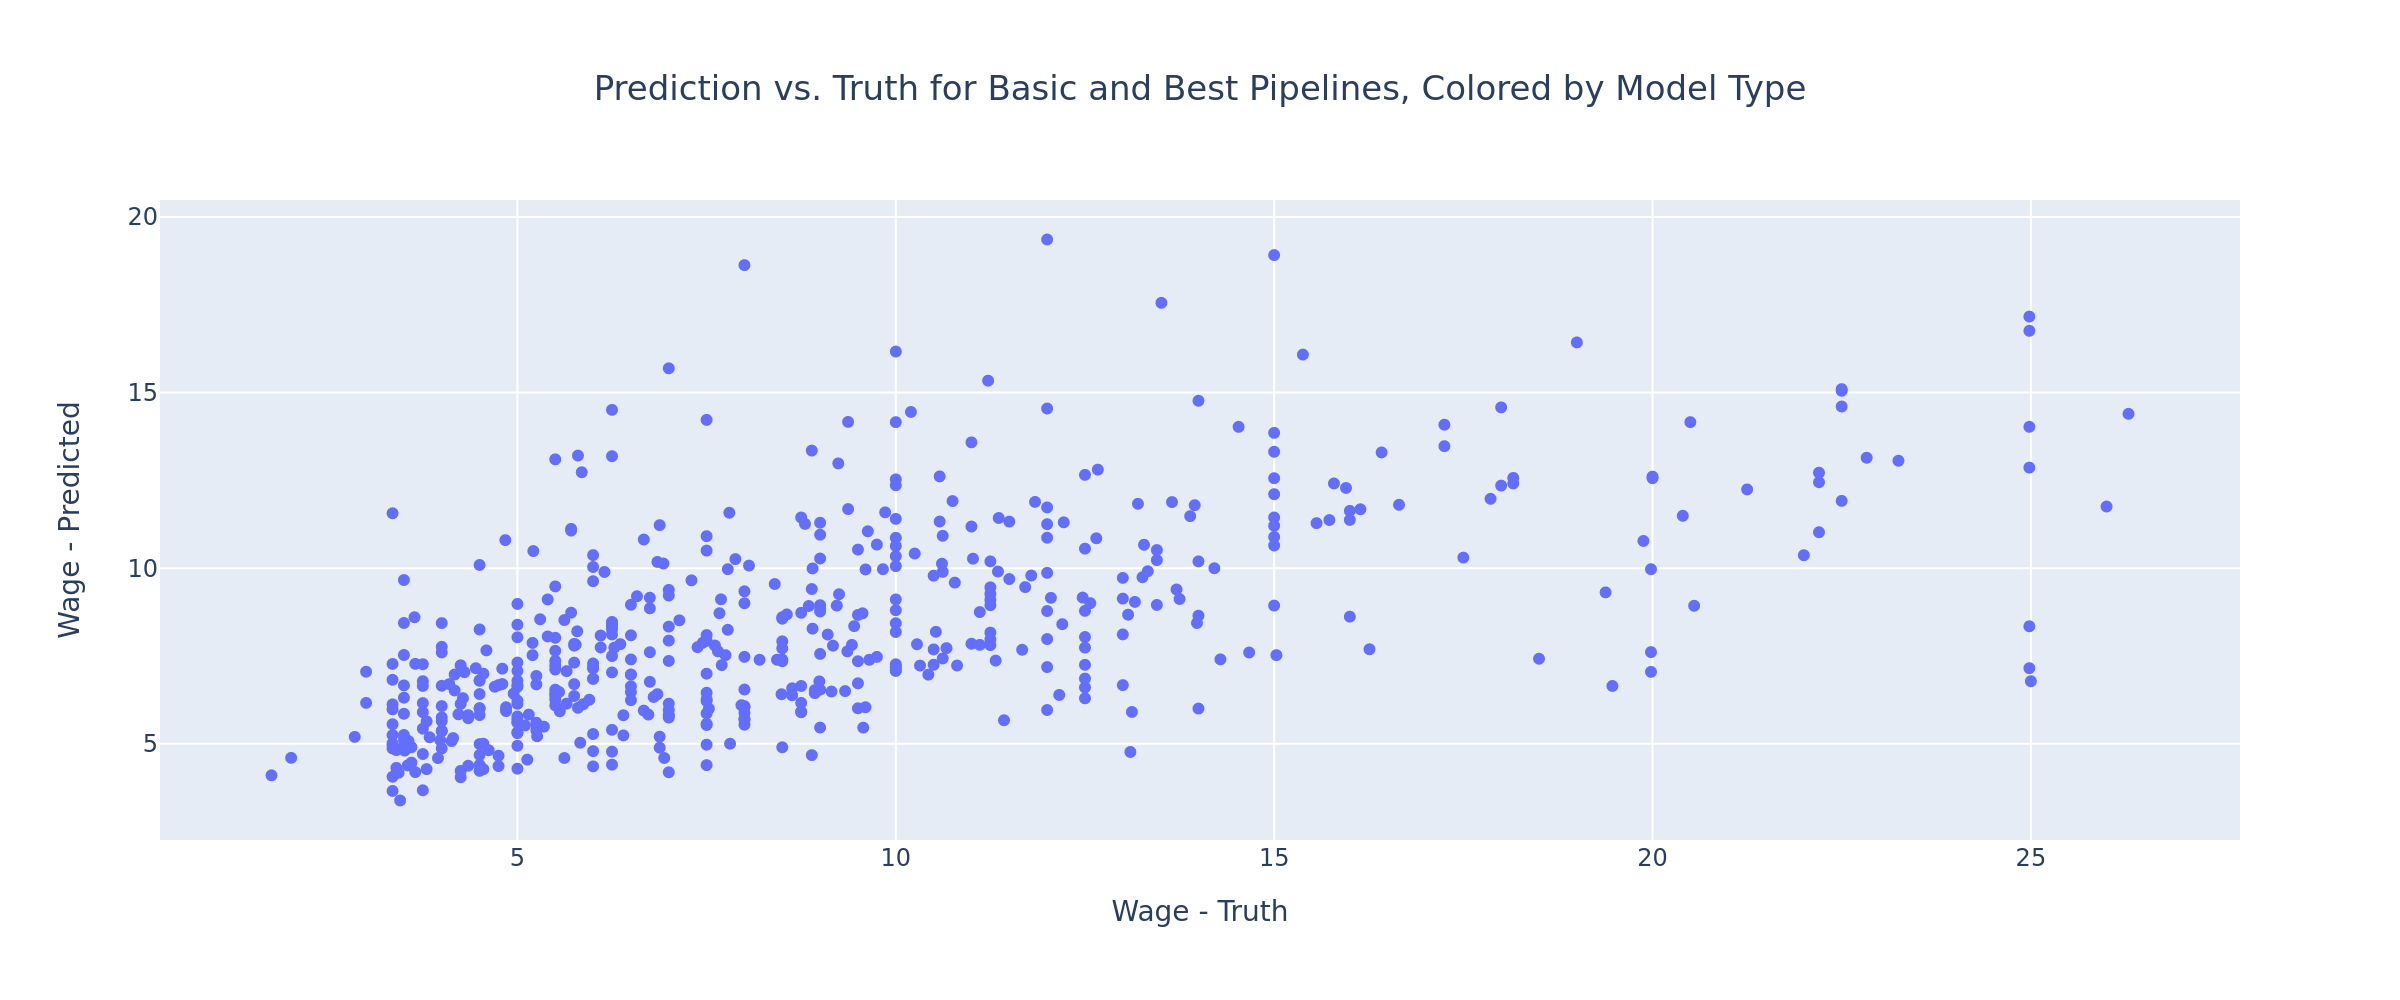

In [82]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=y,
        y=y_pred,
        mode="markers",
        name="Basic Pipeline, MSE = %.4f" % mse_basic,
    )
)

fig.update_layout(
    title="Prediction vs. Truth for Basic and Best Pipelines, Colored by Model Type",
    xaxis_title="Wage - Truth",
    yaxis_title="Wage - Predicted",
)

Image(fig.update_layout(title_x=0.5).to_image(format="png", width=1200, scale=2))

In [83]:
def make_permutation_importance_DataFrame(
    model,
    X: pd.DataFrame,
    y: pd.Series,
    features: list[str],
    **permutation_importance_kwargs,
) -> pd.DataFrame:
    # Compute the importances
    pi = permutation_importance(
        model,
        X,
        y,
        n_repeats=10,
        random_state=42,
        **permutation_importance_kwargs,
    )

    # Get a sorting by the mean importance, then build a frame with all the importances
    # where columns sorted from most important on down
    ordered_features = list(np.array(features)[np.argsort(pi.importances_mean)])[::-1]
    return pd.DataFrame(pi.importances.T, columns=features)[ordered_features]

In [84]:
# Importance per feature
model_features = numeric_features + one_hot_features
df_pi = make_permutation_importance_DataFrame(regression_pipe, X, y, model_features)

df_pi

,category_SOUTH,numeric_EDUCATION,category_OCCUPATION,numeric_AGE,category_UNION,category_SEX,category_SECTOR,category_RACE,numeric_EXPERIENCE,category_MARR
0,0.173277,0.119544,0.106952,0.073676,0.084362,0.030980,0.027883,0.010992,0.011476,-0.001815
1,0.187571,0.143482,0.099288,0.109789,0.091435,0.037060,0.038733,0.008884,0.007457,0.001966
2,0.180573,0.154322,0.115341,0.118772,0.079741,0.012647,0.020927,0.003562,0.003550,0.001561
3,0.160963,0.134476,0.124492,0.088271,0.056964,0.003208,0.021235,0.014729,0.005724,0.000271
4,0.169472,0.179328,0.135856,0.103596,0.075968,0.028848,0.006217,0.013033,0.006489,0.002238
5,0.210750,0.144031,0.122010,0.082612,0.087942,0.025857,0.021970,0.010008,0.006161,0.003422
6,0.188618,0.120389,0.100042,0.108645,0.064749,0.030391,0.037756,0.004903,0.009330,0.001684
7,0.187670,0.139632,0.146630,0.115932,0.073100,0.026317,0.040117,0.010043,0.006333,0.003004
8,0.182290,0.167648,0.139170,0.077287,0.098480,0.046704,0.017177,0.007140,0.005743,-0.000770
9,0.213670,0.136347,0.114691,0.097451,0.107907,0.032913,0.022483,0.012293,0.011737,0.000896


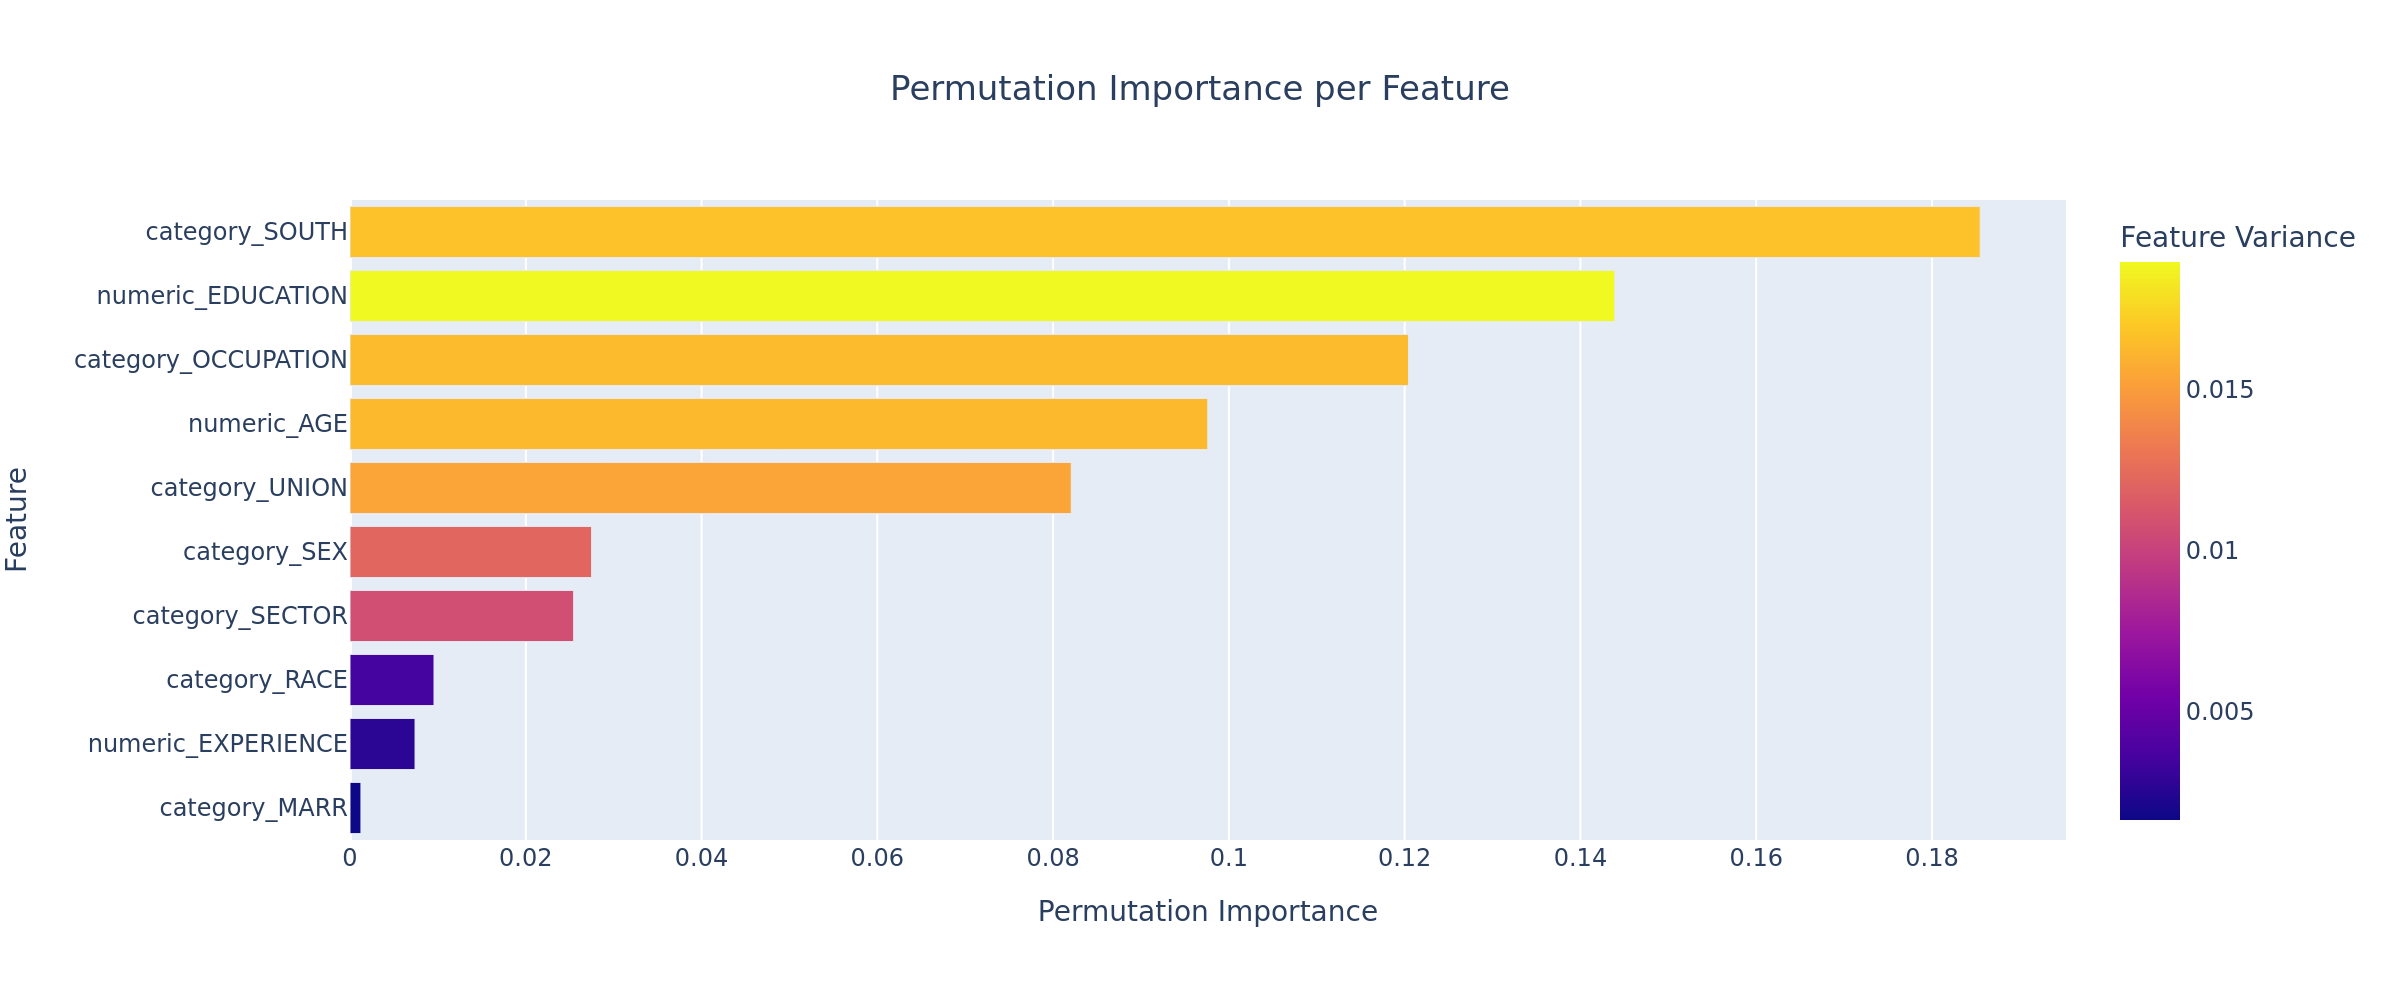

In [85]:
df_pi_reversed = df_pi[df_pi.columns[::-1]]

Image(
    px.bar(
        data_frame=df_pi_reversed.mean(),
        color=df_pi_reversed.std(),
        orientation="h",
        title="Permutation Importance per Feature",
        labels={
            "value": "Permutation Importance",
            "index": "Feature",
            "color": "Feature Variance",
        },
    )
    .update_layout(title_x=0.5)
    .to_image(format="png", width=1200, scale=2)
)